In [43]:
%matplotlib inline

from pyspark.sql import SparkSession
from pyspark import SparkConf, StorageLevel
import pyspark.sql.functions as F
from cleantext import clean
from pyspark.find_spark_home import _find_spark_home
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

nltk.download('stopwords')
print(_find_spark_home())


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\workl\AppData\Roaming\nltk_data...


C:\Users\workl\anaconda3\envs\BigData\Lib\site-packages\pyspark


[nltk_data]   Unzipping corpora\stopwords.zip.


In [12]:
conf = SparkConf().setMaster('local[*]') \
        .set("spark.local.dir", "D:/BigData_UkraineTwitter/tmp/spark-temp")
spark = SparkSession.builder.appName("UkraineStuff").config(conf=conf).getOrCreate()
sc = spark.sparkContext

In [ ]:
df = spark.read.options(header=True, 
                        escape='"', 
                        multiline=True,
                        ).csv('hdfs://localhost:9000/ukraine_tweets/extracted/')

min_df = df.drop('_c0', 'userid', 'username', 'followers', 'acctdesc', 'location', 'following', 'totaltweets', 'usercreatedts', 'tweetid', 'tweetcreatedts', 'retweetcount', 'coordinates', 'favorite_count', 'extractedts')

min_df.repartition(256).persist(StorageLevel.MEMORY_AND_DISK).write.mode('overwrite').parquet('hdfs://localhost:9000/ukraine_tweets/results')

In [13]:
min_df = spark.read.parquet('hdfs://localhost:9000/ukraine_tweets/results')

df_index = min_df.select("*").withColumn("id", F.monotonically_increasing_id())
column_list = df_index.columns
column_list.remove('id')

df_index = df_index.select('id', *column_list)

rows_to_delete = df_index.filter(df_index['language'] != 'en')

df_index = df_index.join(rows_to_delete, on=['id'], how='left_anti')

df_index.repartition(256, 'id').persist(StorageLevel.MEMORY_AND_DISK).write.mode('overwrite').parquet('hdfs://localhost:9000/ukraine_tweets/english_removed')

In [44]:
df_index = spark.read.parquet('hdfs://localhost:9000/ukraine_tweets/english_removed')

@F.udf
def clean_emojis_and_urls(s):
    if s is not None:
        return clean(s, no_emoji=True, no_urls=True, no_line_breaks=True, no_punct=True, no_currency_symbols=True, replace_with_url="", replace_with_currency_symbol="")

df_index = df_index.withColumn('text', F.regexp_replace('text', r'[#][a-zA-Z0-9_#]*', ''))
df_index = df_index.withColumn('text', F.regexp_replace('text', r'[@]', ''))
df_index = df_index.withColumn('text', F.regexp_replace('text', r"['’‘]s", ''))
df_index = df_index.withColumn('text', clean_emojis_and_urls('text'))
df_index = df_index.withColumn('text', F.regexp_replace('text', r'<url>', ''))

df_index.repartition(256, 'id').persist(StorageLevel.MEMORY_AND_DISK).write.mode('overwrite').parquet('hdfs://localhost:9000/ukraine_tweets/text_cleaned')

In [46]:
df_index = spark.read.parquet('hdfs://localhost:9000/ukraine_tweets/text_cleaned')

rows_to_delete = df_index.filter(df_index['text'] == '')

df_index = df_index.join(rows_to_delete, on=['id'], how='left_anti')

df_index.repartition(256, 'id').persist(StorageLevel.MEMORY_AND_DISK).write.mode('overwrite').parquet('hdfs://localhost:9000/ukraine_tweets/empty_text_removed')

In [49]:
df_index = spark.read.parquet('hdfs://localhost:9000/ukraine_tweets/empty_text_removed')

clean_df = df_index.withColumn("words", F.explode(F.split(F.trim("text"), " "))).groupBy("words").count()

clean_df.head(5)

Py4JJavaError: An error occurred while calling o898.parquet.
: java.net.ConnectException: Call From DESKTOP-379K0S0/192.168.0.172 to localhost:9000 failed on connection exception: java.net.ConnectException: Connection refused: no further information; For more details see:  http://wiki.apache.org/hadoop/ConnectionRefused
	at sun.reflect.GeneratedConstructorAccessor126.newInstance(Unknown Source)
	at sun.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
	at java.lang.reflect.Constructor.newInstance(Constructor.java:423)
	at org.apache.hadoop.net.NetUtils.wrapWithMessage(NetUtils.java:913)
	at org.apache.hadoop.net.NetUtils.wrapException(NetUtils.java:828)
	at org.apache.hadoop.ipc.Client.getRpcResponse(Client.java:1616)
	at org.apache.hadoop.ipc.Client.call(Client.java:1558)
	at org.apache.hadoop.ipc.Client.call(Client.java:1455)
	at org.apache.hadoop.ipc.ProtobufRpcEngine2$Invoker.invoke(ProtobufRpcEngine2.java:242)
	at org.apache.hadoop.ipc.ProtobufRpcEngine2$Invoker.invoke(ProtobufRpcEngine2.java:129)
	at com.sun.proxy.$Proxy34.getFileInfo(Unknown Source)
	at org.apache.hadoop.hdfs.protocolPB.ClientNamenodeProtocolTranslatorPB.getFileInfo(ClientNamenodeProtocolTranslatorPB.java:965)
	at sun.reflect.GeneratedMethodAccessor47.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at org.apache.hadoop.io.retry.RetryInvocationHandler.invokeMethod(RetryInvocationHandler.java:422)
	at org.apache.hadoop.io.retry.RetryInvocationHandler$Call.invokeMethod(RetryInvocationHandler.java:165)
	at org.apache.hadoop.io.retry.RetryInvocationHandler$Call.invoke(RetryInvocationHandler.java:157)
	at org.apache.hadoop.io.retry.RetryInvocationHandler$Call.invokeOnce(RetryInvocationHandler.java:95)
	at org.apache.hadoop.io.retry.RetryInvocationHandler.invoke(RetryInvocationHandler.java:359)
	at com.sun.proxy.$Proxy35.getFileInfo(Unknown Source)
	at org.apache.hadoop.hdfs.DFSClient.getFileInfo(DFSClient.java:1739)
	at org.apache.hadoop.hdfs.DistributedFileSystem$29.doCall(DistributedFileSystem.java:1753)
	at org.apache.hadoop.hdfs.DistributedFileSystem$29.doCall(DistributedFileSystem.java:1750)
	at org.apache.hadoop.fs.FileSystemLinkResolver.resolve(FileSystemLinkResolver.java:81)
	at org.apache.hadoop.hdfs.DistributedFileSystem.getFileStatus(DistributedFileSystem.java:1765)
	at org.apache.hadoop.fs.FileSystem.exists(FileSystem.java:1760)
	at org.apache.spark.sql.execution.datasources.DataSource$.$anonfun$checkAndGlobPathIfNecessary$4(DataSource.scala:784)
	at org.apache.spark.sql.execution.datasources.DataSource$.$anonfun$checkAndGlobPathIfNecessary$4$adapted(DataSource.scala:782)
	at org.apache.spark.util.ThreadUtils$.$anonfun$parmap$2(ThreadUtils.scala:372)
	at scala.concurrent.Future$.$anonfun$apply$1(Future.scala:659)
	at scala.util.Success.$anonfun$map$1(Try.scala:255)
	at scala.util.Success.map(Try.scala:213)
	at scala.concurrent.Future.$anonfun$map$1(Future.scala:292)
	at scala.concurrent.impl.Promise.liftedTree1$1(Promise.scala:33)
	at scala.concurrent.impl.Promise.$anonfun$transform$1(Promise.scala:33)
	at scala.concurrent.impl.CallbackRunnable.run(Promise.scala:64)
	at java.util.concurrent.ForkJoinTask$RunnableExecuteAction.exec(ForkJoinTask.java:1402)
	at java.util.concurrent.ForkJoinTask.doExec(ForkJoinTask.java:289)
	at java.util.concurrent.ForkJoinPool$WorkQueue.runTask(ForkJoinPool.java:1067)
	at java.util.concurrent.ForkJoinPool.runWorker(ForkJoinPool.java:1703)
	at java.util.concurrent.ForkJoinWorkerThread.run(ForkJoinWorkerThread.java:172)
Caused by: java.net.ConnectException: Connection refused: no further information
	at sun.nio.ch.SocketChannelImpl.checkConnect(Native Method)
	at sun.nio.ch.SocketChannelImpl.finishConnect(SocketChannelImpl.java:715)
	at org.apache.hadoop.net.SocketIOWithTimeout.connect(SocketIOWithTimeout.java:205)
	at org.apache.hadoop.net.NetUtils.connect(NetUtils.java:586)
	at org.apache.hadoop.ipc.Client$Connection.setupConnection(Client.java:711)
	at org.apache.hadoop.ipc.Client$Connection.setupIOstreams(Client.java:833)
	at org.apache.hadoop.ipc.Client$Connection.access$3800(Client.java:414)
	at org.apache.hadoop.ipc.Client.getConnection(Client.java:1677)
	at org.apache.hadoop.ipc.Client.call(Client.java:1502)
	... 35 more


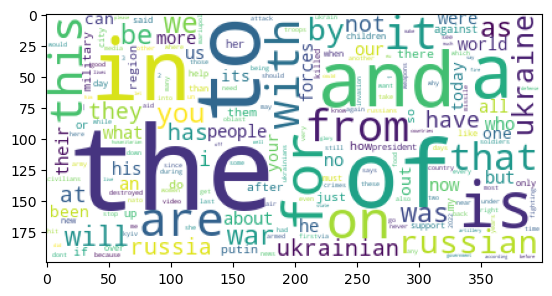

In [48]:

wordcloud = WordCloud(background_color="white")

words = clean_df.rdd.map(lambda x: (x[0], x[1])).collectAsMap()

plt.imshow(wordcloud.generate_from_frequencies(words))


plt.show()